In [1]:
using MatrixNetworks
using SparseArrays
using LinearAlgebra
using Distributions
using StatsBase
using Printf
using Statistics
using Clustering
using BenchmarkTools, Compat
using DelimitedFiles

using Plots,LaTeXStrings
using EllipsoidalGraphEmbedding


In [6]:
using LaTeXStrings
x = 0:0.1:1
y = x.^2
using PyPlot
p=Plots.plot(x,y,xticks = ([0,1,2],[L"0", L"1", L"2"]))
Plots.xlabel!(L"x.^2")
display(p)

### Compute NMI between the retrieved and the true community

In [2]:
## Compute NMI for each graph
path = "data/LFR_data/"
n_graphs = 10

# Set parameters of simulations
n_clusters = 100
d0 = 30
shape = "Ellipsoidal" #shape = "Spherical"

n_rep = 3
mus=zeros(Float64,n_graphs)
NMIs=zeros(Float64,n_graphs,n_rep)
NMIs_louvain=zeros(Float64,n_graphs)

for g=1:n_graphs
    println("\n========== Graph $g/$(n_graphs) ==========")
    
    # load communities
    community_true = readdlm(path*"communities"*string(g-1)*".txt",Int)
    community_louvain = readdlm(path*"louvain_communities"*string(g-1)*".txt",Int)

    # load graph
    edgeList = readdlm(path*"edgeList"*string(g-1)*".txt",Int)

    n_nodes = size(community_true)[1]
    n_edges = size(edgeList)[1]

    # construct sparse adjacency matrix from list of edges
    adj = sparse(edgeList[:,1].+1,edgeList[:,2].+1,vec(ones(Int64,n_edges,1)),n_nodes,n_nodes)
    adj = adj+adj' 
    # only the upper triangular part of adjacency matrix was stored

    # keep only the largest connected component
    adj,vertices = largest_component(adj)
    
    community_true = community_true[vertices]
    community_true = rename_com_unique(community_true)
    
    community_louvain = community_louvain[vertices]
    community_louvain = rename_com_unique(community_louvain)

    # load parameters
    LFR_parameters = readdlm(path*"parameters"*string(g-1)*".txt")
    mu = parse(Float64, split(LFR_parameters[4],"=")[2]) 
    # extract mixing marameter (not very robust)
    mus[g] = mu
    
    for j=1:n_rep
        println("\n  ~~~~~ number_rep = $j/$(n_rep) ~~~~~")
        
         _,community,_ = @time sphere_embed_cluster(adj, d0,shape, n_clusters)
        NMIs[g,j] = mutualinfo(community_true,community)
    end
    NMIs_louvain[g] = mutualinfo(community_true,community_louvain)
end




========== Graph 1/10 ==========



  ~~~~~ number_rep = 1/3 ~~~~~


 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 192 iterations
  1.143121 seconds (27.61 k allocations: 399.752 MiB, 9.75% gc time, 6.66% compilation time)


 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

5
Modularity: 0.80316335243406


Number of communities: 20
 -------------------------------------------- 
The first 5 squared singular values divided by N : 


[0.3989267690489326, 0.26487109132291403, 0.17783802109095423, 0.10090466463619217, 0.055969352180868494]
 -------------------------------------------- 
  2.410380 seconds (537.07 k allocations: 496.558 MiB, 10.89% gc time, 3.16% compilation time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 191 iterations
  0.877242 seconds (5.07 k allocations: 396.400 MiB, 11.02% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

4
Modularity: 0.80316335243406
Number of communities: 20
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.4002364973345871, 0.2680055692153764, 0.1780814323547155, 0.09734234780647666, 0.054962250580638965]
 -------------------------------------------- 
  1.203703 seconds (90.47 k allocations: 461.915 MiB, 9.56% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 194 iterations
  0.875016 seconds (5.15 k allocations: 402.652 MiB, 7.66% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

5
Modularity: 0.8024672900779423
Number of communities: 21
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.39966106099255555, 0.26511349532271344, 0.17676041043130844, 0.10228423723158625, 0.055186677774551655]
 -------------------------------------------- 
  1.241029 seconds (100.90 k allocations: 475.822 MiB, 7.04% gc time)

========== Graph 2/10 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 174 iterations
  0.808900 seconds (4.63 k allocations: 360.982 MiB, 7.75% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

2
Modularity: 0.6546849735710609
Number of communities: 23
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.31928471951888193, 0.23682008966245197, 0.16405911304815188, 0.1338459211170791, 0.10205487582744842]
 -------------------------------------------- 
  1.067489 seconds (65.23 k allocations: 408.820 MiB, 8.71% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 147 iterations
  0.708785 seconds (3.93 k allocations: 304.725 MiB, 10.66% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

3
Modularity: 0.6557887676729761
Number of communities: 21
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.3193398551777944, 0.23532282567291624, 0.1623027229496272, 0.13241348683027307, 0.10867698528943541]
 -------------------------------------------- 
  0.945853 seconds (68.67 k allocations: 355.585 MiB, 7.99% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 199 iterations
  0.953954 seconds (5.28 k allocations: 413.069 MiB, 9.08% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

3
Modularity: 0.6546601188786344
Number of communities: 24
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.3193561859860478, 0.2348082412618911, 0.16421628894309653, 0.13446482155589976, 0.10228889994538604]
 -------------------------------------------- 
  1.252849 seconds (80.34 k allocations: 471.210 MiB, 8.14% gc time)

========== Graph 3/10 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 128 iterations
  0.656097 seconds (3.44 k allocations: 265.138 MiB, 8.91% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

3
Modularity: 0.5187473187028108
Number of communities: 21
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.23691840632550737, 0.21721145250849652, 0.15886377233745955, 0.13503848303468152, 0.1185189916704217]
 -------------------------------------------- 
  0.939818 seconds (74.37 k allocations: 320.355 MiB, 6.22% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 128 iterations
  0.623535 seconds (3.44 k allocations: 265.139 MiB, 11.35% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

3
Modularity: 0.518879504188096
Number of communities: 21
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.23624511029189285, 0.21895316220135713, 0.15880868429287806, 0.1348808738668917, 0.11924029136960351]
 -------------------------------------------- 
  0.905279 seconds (74.37 k allocations: 320.234 MiB, 9.83% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 126 iterations
  0.643888 seconds (3.38 k allocations: 260.971 MiB, 9.59% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

3
Modularity: 0.5190015104385715
Number of communities: 22
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.23724688715559375, 0.21865092227570934, 0.15822951350186204, 0.13507021041429332, 0.11930235971443742]
 -------------------------------------------- 
  1.011124 seconds (68.11 k allocations: 311.814 MiB, 6.11% gc time)

========== Graph 4/10 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 153 iterations
  0.815390 seconds (4.09 k allocations: 317.227 MiB, 9.52% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

6
Modularity: 0.3884144948155741
Number of communities: 20
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.2202269537579144, 0.212747503811648, 0.18094956357233552, 0.1279831914419381, 0.09868125797198193]
 -------------------------------------------- 
  1.248974 seconds (106.02 k allocations: 394.308 MiB, 7.79% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 181 iterations
  0.900164 seconds (4.82 k allocations: 375.566 MiB, 6.89% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

5
Modularity: 0.38745305481653847
Number of communities: 20
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.21967266999703894, 0.21265486133078534, 0.18087790375350626, 0.12780091383390083, 0.09931880884511698]
 -------------------------------------------- 
  1.265928 seconds (108.81 k allocations: 454.054 MiB, 6.39% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 180 iterations
  0.716871 seconds (4.79 k allocations: 373.483 MiB, 7.74% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

4
Modularity: 0.3864963465480676
Number of communities: 21
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.21964751946933897, 0.21292447556949468, 0.18053389288529817, 0.12827734733135598, 0.0988871433178887]
 -------------------------------------------- 
  0.928753 seconds (81.93 k allocations: 433.268 MiB, 7.44% gc time)

========== Graph 5/10 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 162 iterations
  0.663313 seconds (4.32 k allocations: 335.978 MiB, 7.62% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

16
Modularity: 0.264110761976754
Number of communities: 12
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.20846930348664097, 0.19064188253176673, 0.13971566423533108, 0.10810359007766086, 0.09698527195646939]
 -------------------------------------------- 
  1.357054 seconds (248.63 k allocations: 509.156 MiB, 8.10% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 162 iterations
  0.760116 seconds (4.32 k allocations: 335.978 MiB, 6.87% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

8
Modularity: 0.2608650961397452
Number of communities: 15
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.20829370507687564, 0.19055312535227495, 0.13974058360230998, 0.10783693150786312, 0.09708777076475425]
 -------------------------------------------- 
  1.421797 seconds (176.45 k allocations: 461.522 MiB, 6.42% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 159 iterations
  0.896753 seconds (4.24 k allocations: 329.728 MiB, 8.46% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

12
Modularity: 0.25988877274428995
Number of communities: 13
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.20827256132503588, 0.19067180072441914, 0.1398732208408536, 0.1080435398791655, 0.09680639367046935]
 -------------------------------------------- 
  1.855609 seconds (209.40 k allocations: 477.089 MiB, 7.33% gc time)

========== Graph 6/10 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 198 iterations
  1.118348 seconds (5.26 k allocations: 410.987 MiB, 6.43% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

23
Modularity: 0.19831345204654194
Number of communities: 7
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.17608859884147987, 0.15729166477223125, 0.1365259218569979, 0.12668430892478882, 0.09946654208492611]
 -------------------------------------------- 
  2.233606 seconds (308.49 k allocations: 620.468 MiB, 5.97% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 179 iterations
  0.879593 seconds (4.76 k allocations: 371.399 MiB, 9.42% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

18
Modularity: 0.2074227735007789
Number of communities: 7
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.17596075262171176, 0.15726219791612578, 0.13644223271637274, 0.1263894650177807, 0.09962989701540483]
 -------------------------------------------- 
  1.930784 seconds (254.63 k allocations: 546.190 MiB, 6.73% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 205 iterations
  1.013192 seconds (5.44 k allocations: 425.571 MiB, 8.61% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

15
Modularity: 0.19829857744136473
Number of communities: 8
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.175929549991694, 0.15718670115800948, 0.13629980501627417, 0.12698940001547318, 0.09950481571853519]
 -------------------------------------------- 
  1.748509 seconds (216.38 k allocations: 575.282 MiB, 7.43% gc time)

========== Graph 7/10 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 226 iterations
  1.052468 seconds (5.99 k allocations: 469.325 MiB, 9.19% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

18
Modularity: 0.1717149026121046
Number of communities: 7
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.14825809408222704, 0.1381611785691239, 0.12437437870417772, 0.10545555908789593, 0.09664609006569494]
 -------------------------------------------- 
  2.119915 seconds (304.99 k allocations: 675.916 MiB, 7.65% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 216 iterations
  0.971503 seconds (5.73 k allocations: 448.491 MiB, 8.36% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

17
Modularity: 0.1785500519246113
Number of communities: 7
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.14819840708536114, 0.13804870089148574, 0.12416716224614116, 0.10566217212205146, 0.09674322489339018]
 -------------------------------------------- 
  2.015349 seconds (294.54 k allocations: 648.314 MiB, 6.26% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 214 iterations
  0.983407 seconds (5.67 k allocations: 444.323 MiB, 8.27% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

18
Modularity: 0.16974714587845258
Number of communities: 6
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.14833308150563404, 0.1381692299922197, 0.12427766646722109, 0.10539217921216788, 0.09663507436499219]
 -------------------------------------------- 
  1.855632 seconds (241.09 k allocations: 609.603 MiB, 6.88% gc time)

========== Graph 8/10 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 215 iterations
  0.938227 seconds (5.70 k allocations: 446.406 MiB, 8.57% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

23
Modularity: 0.17053607786964647
Number of communities: 7
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.16709924304379553, 0.133479713014609, 0.12062043438557796, 0.1151402551147863, 0.10942430249052464]
 -------------------------------------------- 
  2.158579 seconds (345.77 k allocations: 679.060 MiB, 6.99% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 214 iterations
  0.995965 seconds (5.67 k allocations: 444.323 MiB, 9.41% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

26
Modularity: 0.17483209599775582
Number of communities: 7
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.1669260912779087, 0.13327085876561043, 0.12056268814989989, 0.11519195614724016, 0.10925052652511102]
 -------------------------------------------- 
  2.075500 seconds (310.77 k allocations: 654.125 MiB, 6.96% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 213 iterations
  1.106333 seconds (5.65 k allocations: 442.240 MiB, 21.73% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

20
Modularity: 0.1735714593200379
Number of communities: 6
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.1669830619122601, 0.133338054563855, 0.1203996683455911, 0.11522586113504948, 0.10940536272015049]
 -------------------------------------------- 
  2.104634 seconds (302.56 k allocations: 646.730 MiB, 14.91% gc time)

========== Graph 9/10 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 234 iterations
  1.096053 seconds (6.19 k allocations: 485.993 MiB, 7.93% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

15
Modularity: 0.1735192572922616
Number of communities: 8
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.16737044686617852, 0.15628380129411693, 0.13105359095493882, 0.11079517672250205, 0.10433925991062244]
 -------------------------------------------- 
  2.115108 seconds (282.64 k allocations: 677.693 MiB, 6.30% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 232 iterations
  0.989805 seconds (6.14 k allocations: 481.826 MiB, 7.91% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

18
Modularity: 0.1728189492485158
Number of communities: 6
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.1674229596711331, 0.15633024573286353, 0.13111692786726678, 0.11065200728132447, 0.10434144034388791]
 -------------------------------------------- 
  1.657112 seconds (255.92 k allocations: 656.150 MiB, 8.87% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 232 iterations
  0.820338 seconds (6.14 k allocations: 481.826 MiB, 8.80% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

22
Modularity: 0.17067253604952926
Number of communities: 7
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.16722452267723809, 0.15619132013540257, 0.13118394927361074, 0.11081274633366124, 0.1043005822282928]
 -------------------------------------------- 
  1.686568 seconds (348.25 k allocations: 715.958 MiB, 7.88% gc time)

========== Graph 10/10 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 202 iterations
  0.702079 seconds (5.36 k allocations: 419.321 MiB, 8.83% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

19
Modularity: 0.17216385428791386
Number of communities: 7
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.15631791541661366, 0.14756779309208715, 0.13520845477761076, 0.10959911520183652, 0.09637051438684908]
 -------------------------------------------- 
  1.453142 seconds (306.46 k allocations: 627.108 MiB, 8.11% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 202 iterations
  0.704028 seconds (5.36 k allocations: 419.320 MiB, 8.32% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

16
Modularity: 0.1723916903691625
Number of communities: 6
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.156495338142484, 0.1475758307808092, 0.13502811826832617, 0.10952252649189173, 0.09638654851221842]
 -------------------------------------------- 
  1.307072 seconds (246.90 k allocations: 588.531 MiB, 7.39% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 199 iterations
  0.699502 seconds (5.28 k allocations: 413.069 MiB, 9.07% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

30
Modularity: 0.17458991286603695
Number of communities: 7
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.15652796796139049, 0.1477668885769775, 0.1350133061409138, 0.10960536431007883, 0.09629105223514217]
 -------------------------------------------- 
  1.524517 seconds (337.02 k allocations: 639.769 MiB, 7.88% gc time)


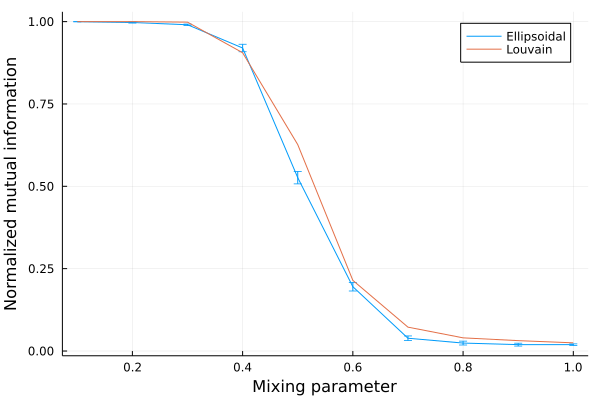

In [3]:
using StatsBase
using LaTeXStrings
# Plot Normalized mutual information vs Mixing parameter
m = mean(NMIs,dims=2);
s = std(NMIs,dims=2);
plot(mus, m, yerror = s,
markerstrokecolor=:auto,
xlabel = "Mixing parameter ",
ylabel = "Normalized mutual information",
labels = "Ellipsoidal")

plot!(mus, NMIs_louvain,
markerstrokecolor=:auto,
xlabel = "Mixing parameter",
ylabel = "Normalized mutual information",
labels = "Louvain")
savefig("figures/nmi_vs_mu.pdf")
plot!()

### Estimating the impact of $d_0$ on embedding quality

In [4]:
g = 4

# Set parameters of simulations
n_clusters = 100
d0s = 10:5:100

n_updates = 100 # max total by default
shape = "Ellipsoidal" #shape = "Spherical"

n_rep = 3
NMIs=zeros(Float64,length(d0s),n_rep)

# load communities
community_true = readdlm(path*"communities"*string(g-1)*".txt",Int)

# load graph
edgeList = readdlm(path*"edgeList"*string(g-1)*".txt",Int)

n_nodes = size(community_true)[1]
n_edges = size(edgeList)[1]

# construct sparse adjacency matrix from list of edges
adj = sparse(edgeList[:,1].+1,edgeList[:,2].+1,vec(ones(Int64,n_edges,1)),n_nodes,n_nodes)
adj = adj+adj' # only the upper triangular part of adjacency matrix was stored

# keep only the largest connected component
adj,vertices = largest_component(adj);

community_true = community_true[vertices]
community_true = rename_com_unique(community_true)

# load parameters
LFR_parameters = readdlm(path*"parameters"*string(g-1)*".txt")
mu = parse(Float64, split(LFR_parameters[4],"=")[2]) # extract mixing marameter (not very robust)
print("mu=$mu")

for i=1:length(d0s)
    println("\n========== d0 step $i/$(length(d0s)) ==========")
    d0=d0s[i]
    for j=1:n_rep
        println("\n  ~~~~~ number_rep = $j/$(n_rep) ~~~~~")
        
        _,community,_ = @time sphere_embed_cluster(adj, d0,shape, n_clusters)

        NMIs[i,j] = mutualinfo(community_true,community)
    end
end


mu=0.4
========== d0 step 1/19 ==========



  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------
The iteration has become stationary after 

159 iterations
  0.185186 seconds (4.24 k allocations: 111.441 MiB, 18.69% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 10


Number of updates: 13
Modularity: 0.3624561456983106
Number of communities: 12
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.21845155790348986, 0.21304565351778607, 0.1826733376410146, 0.1284104382603634, 0.09785451213848781]
 -------------------------------------------- 
  0.452753 seconds (219.43 k allocations: 241.251 MiB, 12.01% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 122 iterations
  0.141087 seconds (3.28 k allocations: 85.397 MiB, 6.88% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 10
Number of updates: 

10
Modularity: 0.37047830999371006
Number of communities: 13
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.2190616288453092, 0.21229017450272608, 0.18212744508801626, 

0.127169651023969, 0.10001663521075446]
 -------------------------------------------- 
  0.447719 seconds (154.56 k allocations: 177.932 MiB, 7.47% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 154 iterations
  0.247535 seconds (4.11 k allocations: 107.921 MiB, 6.11% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 10
Number of updates: 

10
Modularity: 0.3792336709880102
Number of communities: 15
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.2200254087037201, 0.2121049028306464, 0.17967999739298465, 0.12930770321249768, 0.0980194486081061]
 -------------------------------------------- 
  0.461901 seconds (140.98 k allocations: 192.748 MiB, 8.67% gc time)

========== d0 step 2/19 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 202 iterations
  0.331040 seconds (5.36 k allocations: 211.022 MiB, 9.09% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 15
Number of updates: 

6
Modularity: 0.37213921012151613
Number of communities: 16
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.21980648914689022, 0.21308229445617613, 0.18112791324038108, 0.12861620051200104, 0.09901817314387958]
 -------------------------------------------- 
  0.485216 seconds (113.36 k allocations: 281.745 MiB, 8.07% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 131 iterations
  0.229689 seconds (3.52 k allocations: 136.587 MiB, 13.72% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 15
Number of updates: 

8
Modularity: 0.37884790118782236
Number of communities: 16
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.220290362607192, 0.21313790332818602, 0.18195784963785136, 0.12742408672688227, 0.09870830908749614]
 -------------------------------------------- 
  0.416701 seconds (130.11 k allocations: 219.124 MiB, 9.75% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 128 iterations
  0.224546 seconds (3.44 k allocations: 133.443 MiB, 8.85% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 15
Number of updates: 

6
Modularity: 0.3828252175055739
Number of communities: 17
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22002330535550363, 0.21345883346801028, 0.18176133078140636, 0.1284285786152747, 0.09926153961889524]
 -------------------------------------------- 
  0.377698 seconds (105.28 k allocations: 200.944 MiB, 8.42% gc time)

========== d0 step 3/19 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 151 iterations
  0.339642 seconds (4.04 k allocations: 209.320 MiB, 9.22% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 20
Number of updates: 

4
Modularity: 0.38608962253823254
Number of communities: 19
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.21995469491711797, 0.21282423894439648, 0.18162696884605156, 0.1284776285494624, 0.09872937565909497]
 -------------------------------------------- 
  0.480554 seconds (85.23 k allocations: 265.972 MiB, 8.90% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 120 iterations
  0.268792 seconds (3.23 k allocations: 166.138 MiB, 11.36% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 20
Number of updates: 

5
Modularity: 0.3860726016841166
Number of communities: 20
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22022522936540787, 0.2135410016282924, 0.18204073039261884, 0.12966682553094688, 0.09825498821312201]
 -------------------------------------------- 
  0.418605 seconds (90.61 k allocations: 226.999 MiB, 9.53% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 210 iterations
  0.472486 seconds (5.57 k allocations: 291.504 MiB, 10.94% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 20
Number of updates: 

6
Modularity: 0.387402782269276
Number of communities: 19
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22014458067976525, 0.21274159909913187, 0.18094393615109652, 0.12869600261608655, 0.09871646072757577]
 -------------------------------------------- 
  0.649564 seconds (107.41 k allocations: 361.563 MiB, 9.15% gc time)

========== d0 step 4/19 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 153 iterations
  0.440952 seconds (4.09 k allocations: 264.644 MiB, 8.93% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 25
Number of updates: 

5
Modularity: 0.3876664132292699
Number of communities: 20
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.219945121957247, 0.2128610419799831, 0.18129195015952163, 0.12833986518396528, 0.09877005067348962]
 -------------------------------------------- 
  0.653787 seconds (108.07 k allocations: 339.390 MiB, 7.48% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 162 iterations
  0.454011 seconds (4.32 k allocations: 280.286 MiB, 10.94% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 25
Number of updates: 

5
Modularity: 0.3885405753712471
Number of communities: 19
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.21980663208420526, 0.21302613743831977, 0.18079759025116474, 0.12794351108265598, 0.09905275601573409]
 -------------------------------------------- 
  0.635522 seconds (93.85 k allocations: 345.606 MiB, 9.01% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 206 iterations
  1.257370 seconds (5.46 k allocations: 356.762 MiB, 5.00% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 25
Number of updates: 

8
Modularity: 0.38820609803197714
Number of communities: 20
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.2201096358157882, 0.21302782208842946, 0.1806280554002031, 0.12829797467249218, 0.09888955731470332]
 -------------------------------------------- 
  1.643314 seconds (101.19 k allocations: 426.228 MiB, 5.15% gc time)

========== d0 step 5/19 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 195 iterations
  0.807909 seconds (5.18 k allocations: 404.735 MiB, 11.04% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

5
Modularity: 0.3878649452742339
Number of communities: 20
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.21978744355577576, 0.21281218401641147, 0.18088269536778068, 0.12784475132527748, 0.09956092158254468]
 -------------------------------------------- 
  1.108666 seconds (105.04 k allocations: 480.083 MiB, 8.74% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 151 iterations
  0.673970 seconds (4.04 k allocations: 313.060 MiB, 7.81% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

7
Modularity: 0.38765597165422533
Number of communities: 20
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22001876042267854, 0.2128996040836348, 0.18098987406954872, 0.12865380896395934, 0.0983521605729533]
 -------------------------------------------- 
  0.991014 seconds (112.16 k allocations: 394.230 MiB, 6.01% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 150 iterations
  0.614721 seconds (4.01 k allocations: 310.976 MiB, 7.66% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 30
Number of updates: 

6
Modularity: 0.38792927925402243
Number of communities: 20
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22014231585608873, 0.21288019987660398, 0.18129925037338782, 0.12827878240066212, 0.09880257412585478]
 -------------------------------------------- 
  0.910399 seconds (103.90 k allocations: 386.663 MiB, 5.98% gc time)

========== d0 step 6/19 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 153 iterations
  0.665661 seconds (4.09 k allocations: 369.873 MiB, 8.63% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 35
Number of updates: 

6
Modularity: 0.38683948061348544
Number of communities: 22
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.21986639557489965, 0.2127373881352277, 0.18093175545632406, 0.12823365189578512, 0.09879037445952829]
 -------------------------------------------- 
  0.976845 seconds (106.07 k allocations: 450.133 MiB, 6.90% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 151 iterations
  0.650321 seconds (4.04 k allocations: 365.014 MiB, 9.01% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 35
Number of updates: 

10
Modularity: 0.38844695649363514
Number of communities: 20
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22013543181682255, 0.21267182499276627, 0.1810920764070999, 0.12834354733106412, 0.09854239011207781]
 -------------------------------------------- 
  1.073093 seconds (149.40 k allocations: 475.977 MiB, 6.27% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 151 iterations
  0.649440 seconds (4.04 k allocations: 365.015 MiB, 9.06% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 35
Number of updates: 

6
Modularity: 0.38793911473283754
Number of communities: 20
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22038148096889956, 0.212637610263981, 0.1814497436290724, 0.12853767373016114, 0.09829487462895277]
 -------------------------------------------- 
  0.988674 seconds (112.22 k allocations: 449.558 MiB, 6.99% gc time)

========== d0 step 7/19 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 148 iterations
  0.717310 seconds (3.96 k allocations: 408.688 MiB, 9.28% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 40
Number of updates: 

6
Modularity: 0.38725500764855825
Number of communities: 20
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22003053906812978, 0.212860784427273, 0.18089177673704865, 0.1284703770266295, 0.09860302181410227]
 -------------------------------------------- 
  1.102132 seconds (105.95 k allocations: 491.477 MiB, 6.92% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 148 iterations
  0.758730 seconds (3.96 k allocations: 408.688 MiB, 7.89% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 40
Number of updates: 

7
Modularity: 0.38782860040032946
Number of communities: 22
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.21999301120153922, 0.21288961104295354, 0.18166889859076943, 0.12821295799044022, 0.09839865824468934]
 -------------------------------------------- 
  1.110687 seconds (114.22 k allocations: 498.050 MiB, 6.21% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 151 iterations
  0.853707 seconds (4.04 k allocations: 417.015 MiB, 8.09% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 40
Number of updates: 

5
Modularity: 0.3886395947752633
Number of communities: 20
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.21994429495955353, 0.21292594926802066, 0.18100511769551936, 0.12833066412145244, 0.09821430385909272]
 -------------------------------------------- 
  1.176133 seconds (103.97 k allocations: 498.697 MiB, 6.62% gc time)

========== d0 step 8/19 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 152 iterations
  0.851884 seconds (4.06 k allocations: 472.214 MiB, 7.96% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 45
Number of updates: 

6
Modularity: 0.387730053333375
Number of communities: 23
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.21979912995661277, 0.21261077177611756, 0.1811809748814614, 0.12846634696545825, 0.09865308778004929]
 -------------------------------------------- 
  1.758313 seconds (106.07 k allocations: 558.949 MiB, 4.65% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 151 iterations
  0.946065 seconds (4.04 k allocations: 469.090 MiB, 7.28% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 45
Number of updates: 

6
Modularity: 0.38803243683229566
Number of communities: 22
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.2201674379760741, 0.21297470956626138, 0.18128670695834562, 0.12838787408374802, 0.09855136901503112]
 -------------------------------------------- 
  1.423002 seconds (114.31 k allocations: 562.280 MiB, 6.37% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 152 iterations
  0.819464 seconds (4.06 k allocations: 472.213 MiB, 8.24% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 45
Number of updates: 

10
Modularity: 0.38770678341813347
Number of communities: 22
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22002329304064114, 0.21277396406858307, 0.18119960366807947, 0.12861290751974583, 0.09827715889909877]
 -------------------------------------------- 
  1.560076 seconds (161.85 k allocations: 601.380 MiB, 5.72% gc time)

========== d0 step 9/19 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 154 iterations
  0.951761 seconds (4.27 k allocations: 531.613 MiB, 7.49% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 50
Number of updates: 

7
Modularity: 0.38814174733229256
Number of communities: 22
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22001325616959524, 0.21278897129149338, 0.1811924048254577, 0.12834200133212784, 0.09862795541662749]
 -------------------------------------------- 
  1.606827 seconds (124.87 k allocations: 636.532 MiB, 5.72% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 153 iterations
  0.909049 seconds (4.24 k allocations: 528.145 MiB, 8.28% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 50
Number of updates: 

10
Modularity: 0.3864530629173281
Number of communities: 25
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22012606966150255, 0.21259986303560582, 0.18120538001914813, 0.128122166977112, 0.09856466065909852]
 -------------------------------------------- 
  1.447238 seconds (133.14 k allocations: 639.918 MiB, 5.99% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 149 iterations
  0.988909 seconds (4.13 k allocations: 514.267 MiB, 7.94% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 50
Number of updates: 

6
Modularity: 0.38690135676856374
Number of communities: 25
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.2202871249008285, 0.21251745216093482, 0.181028111645243, 0.12820054765317287, 0.09852326667565157]
 -------------------------------------------- 
  1.475211 seconds (112.35 k allocations: 609.781 MiB, 6.01% gc time)

========== d0 step 10/19 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 152 iterations
  1.082531 seconds (4.21 k allocations: 577.208 MiB, 7.68% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 55
Number of updates: 

7
Modularity: 0.3860358638926565
Number of communities: 25
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.2200718177206779, 0.21283451403818374, 0.1808591284233385, 0.12804815219107568, 0.09867463387712212]
 -------------------------------------------- 
  1.633719 seconds (118.69 k allocations: 682.000 MiB, 6.47% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 152 iterations
  1.196983 seconds (4.21 k allocations: 577.208 MiB, 7.02% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 55
Number of updates: 

7
Modularity: 0.38691788856572207
Number of communities: 27
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.21986403692657056, 0.21290071667091318, 0.1810447048479147, 0.12833716882393212, 0.09874356099634782]
 -------------------------------------------- 
  2.008529 seconds (118.66 k allocations: 682.017 MiB, 5.27% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 151 iterations
  1.051647 seconds (4.19 k allocations: 573.392 MiB, 7.13% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 55
Number of updates: 

8
Modularity: 0.3849083577066921
Number of communities: 23
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.219913441012827, 0.21276286915648535, 0.1807401885591585, 0.12820146883021427, 0.09872178695703834]
 -------------------------------------------- 
  1.683598 seconds (131.05 k allocations: 687.733 MiB, 5.02% gc time)

========== d0 step 11/19 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 152 iterations
  1.110697 seconds (4.21 k allocations: 629.785 MiB, 8.19% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 60
Number of updates: 

8
Modularity: 0.38685390988372326
Number of communities: 26
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22021571416339653, 0.21275391676900957, 0.18121086802994119, 0.12861351498019513, 0.09824347791466467]
 -------------------------------------------- 
  1.808505 seconds (129.05 k allocations: 746.467 MiB, 6.26% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 153 iterations
  1.118923 seconds (4.24 k allocations: 633.949 MiB, 8.14% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 60
Number of updates: 

6
Modularity: 0.3855414649282334
Number of communities: 26
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.2198745970869291, 0.2124826350326006, 0.18073524183918055, 0.12823225875943792, 0.09867500973011953]
 -------------------------------------------- 
  1.707720 seconds (112.55 k allocations: 736.853 MiB, 5.92% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 152 iterations
  1.139915 seconds (4.21 k allocations: 629.785 MiB, 8.08% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 60
Number of updates: 

10
Modularity: 0.38686873625149076
Number of communities: 26
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22002309455841706, 0.21269388341279133, 0.18108545887436583, 0.1284124444069522, 0.09870181288734771]
 -------------------------------------------- 
  1.964535 seconds (143.52 k allocations: 758.662 MiB, 5.81% gc time)

========== d0 step 12/19 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 151 iterations
  1.300262 seconds (4.19 k allocations: 677.926 MiB, 7.13% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 65
Number of updates: 

8
Modularity: 0.3862988929363949
Number of communities: 24
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22004122369386223, 0.21265467963275583, 0.1809143306907475, 0.12840629338344828, 0.09856836423111823]
 -------------------------------------------- 
  2.220392 seconds (131.12 k allocations: 800.581 MiB, 5.32% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 149 iterations
  1.415922 seconds (4.13 k allocations: 668.900 MiB, 6.95% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 65
Number of updates: 

8
Modularity: 0.38577155159690096
Number of communities: 24
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22025231046898935, 0.21281405919207294, 0.1810484237051805, 0.1281708525399269, 0.09850244070010988]
 -------------------------------------------- 
  2.224068 seconds (131.06 k allocations: 791.391 MiB, 5.53% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 179 iterations
  2.104995 seconds (4.94 k allocations: 804.273 MiB, 9.11% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 65
Number of updates: 

7
Modularity: 0.386460202312915
Number of communities: 23
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.2195561155694607, 0.21270740287704157, 0.18076430031747945, 0.12773029530196767, 0.09953866974645072]
 -------------------------------------------- 
  3.027156 seconds (121.55 k allocations: 917.523 MiB, 6.70% gc time)

========== d0 step 13/19 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 151 iterations
  2.314347 seconds (4.18 k allocations: 730.276 MiB, 7.49% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 70
Number of updates: 

9
Modularity: 0.38215513841402876
Number of communities: 28
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.2201674071941637, 0.21297959090779758, 0.18113989478477246, 0.12812448755888803, 0.098648749154289]
 -------------------------------------------- 
  5.143354 seconds (155.98 k allocations: 880.190 MiB, 4.61% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~


 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 150 iterations
  3.559710 seconds (4.16 k allocations: 725.413 MiB, 8.77% gc time)


 -------------- Clustering ------- 
dimension of embedding used for clustering: 70
Number of updates: 

8
Modularity: 0.383468574023356
Number of communities: 31
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.220033089057419, 0.21268832843212354, 0.18112339946493194, 0.1284839288902836, 0.09839895103746803]
 -------------------------------------------- 
  6.467057 seconds (131.26 k allocations: 853.011 MiB, 5.10% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 149 iterations
  9.524921 seconds (4.13 k allocations: 720.554 MiB, 3.18% gc time)


 -------------- Clustering ------- 
dimension of embedding used for clustering: 70
Number of updates: 

7
Modularity: 0.38330099050586625
Number of communities: 29
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.2201123766189677, 0.2128891339806903, 0.18103726709116874, 0.1284281213706589, 0.09859756508185832]
 -------------------------------------------- 
 14.695826 seconds (137.38 k allocations: 853.822 MiB, 2.72% gc time)

========== d0 step 14/19 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 152 iterations
  5.904282 seconds (4.21 k allocations: 787.903 MiB, 4.65% gc time)


 -------------- Clustering ------- 
dimension of embedding used for clustering: 75
Number of updates: 

8
Modularity: 0.3822279284812134
Number of communities: 34
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22002722348238377, 0.21289874599954284, 0.18116201687381422, 0.12811177399280907, 0.09850360193791208]
 -------------------------------------------- 
  9.464702 seconds (131.34 k allocations: 921.114 MiB, 3.27% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 150 iterations
  1.428648 seconds (4.16 k allocations: 777.483 MiB, 7.82% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 75
Number of updates: 

10
Modularity: 0.3833255771129169
Number of communities: 29
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.2201516150351747, 0.21263056849906078, 0.1813097207585516, 0.1281752773076262, 0.09839735258546446]
 -------------------------------------------- 
  2.639848 seconds (166.37 k allocations: 943.630 MiB, 5.23% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 149 iterations
  1.706566 seconds (4.13 k allocations: 772.273 MiB, 6.94% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 75
Number of updates: 

7
Modularity: 0.3822878818482531
Number of communities: 31
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22017415559002665, 0.21271195809320562, 0.18106768620361124, 0.1284521929099342, 0.09850652312167282]
 -------------------------------------------- 
  2.492674 seconds (118.78 k allocations: 893.398 MiB, 5.78% gc time)

========== d0 step 15/19 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 151 iterations
  1.499963 seconds (4.18 k allocations: 835.147 MiB, 8.00% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 80
Number of updates: 

8
Modularity: 0.3838595060914301
Number of communities: 34
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22023163663303516, 0.21283371826740904, 0.1810221736680898, 0.12816528060194005, 0.09849451542875515]
 -------------------------------------------- 
  2.406656 seconds (131.33 k allocations: 970.373 MiB, 6.12% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 151 iterations
  1.470377 seconds (4.18 k allocations: 835.147 MiB, 9.34% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 80
Number of updates: 

8
Modularity: 0.38414865997265013
Number of communities: 31
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.2200398290843922, 0.2127720286689816, 0.18111757862650787, 0.12843784576379186, 0.09842294248046339]
 -------------------------------------------- 
  2.550364 seconds (156.11 k allocations: 994.076 MiB, 6.38% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 149 iterations
  1.563247 seconds (4.13 k allocations: 824.028 MiB, 8.13% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 80
Number of updates: 

8
Modularity: 0.3805572513942283
Number of communities: 31
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22023134830419108, 0.21268278439838592, 0.1809306151734959, 0.12844542703289033, 0.09843821672537509]
 -------------------------------------------- 
  2.838461 seconds (147.84 k allocations: 975.762 MiB, 6.09% gc time)

========== d0 step 16/19 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 150 iterations
  2.177641 seconds (4.16 k allocations: 881.776 MiB, 8.18% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 85
Number of updates: 

7
Modularity: 0.3799370770122338
Number of communities: 36
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22016653276682768, 0.212671408903451, 0.1810060169090592, 0.1285175524495279, 0.09828116947623951]
 -------------------------------------------- 
  3.454292 seconds (129.25 k allocations: 1021.504 MiB, 6.03% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 152 iterations
  2.397821 seconds (4.21 k allocations: 893.595 MiB, 7.06% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 85
Number of updates: 

8
Modularity: 0.38226747939517347
Number of communities: 33
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22003049521453702, 0.21278440377940172, 0.1810730426199184, 0.1282085782293334, 0.09857212742277226]
 -------------------------------------------- 
  3.353388 seconds (131.45 k allocations: 1.012 GiB, 5.87% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 151 iterations
  1.658720 seconds (4.18 k allocations: 887.685 MiB, 8.44% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 85
Number of updates: 

11
Modularity: 0.3834659657195818
Number of communities: 35
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22010733506044142, 0.21281113608162058, 0.18109365349065754, 0.12843983095261935, 0.09845278286674676]
 -------------------------------------------- 
  2.973566 seconds (179.04 k allocations: 1.052 GiB, 5.59% gc time)

========== d0 step 17/19 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 150 iterations
  1.754546 seconds (4.16 k allocations: 933.999 MiB, 8.55% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 90
Number of updates: 

12
Modularity: 0.3819576806223821
Number of communities: 32
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22006188342919106, 0.21272092899345169, 0.18101099173454266, 0.12822376100776092, 0.09865615555030821]
 -------------------------------------------- 
  3.423354 seconds (185.28 k allocations: 1.106 GiB, 5.64% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 152 iterations
  2.186367 seconds (4.21 k allocations: 946.516 MiB, 7.77% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 90
Number of updates: 

12
Modularity: 0.37956635511843545
Number of communities: 38
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.220183224152002, 0.21276100642415008, 0.18104101500076056, 0.12798161216956405, 0.09887718855614212]
 -------------------------------------------- 
  4.017287 seconds (170.79 k allocations: 1.104 GiB, 5.10% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 151 iterations
  1.823873 seconds (4.19 k allocations: 940.258 MiB, 8.45% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 90
Number of updates: 

9
Modularity: 0.3780685826558383
Number of communities: 35
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22015713296409162, 0.21286543783126605, 0.18119401210955244, 0.1282705399038513, 0.09855489270948375]
 -------------------------------------------- 
  3.133269 seconds (143.83 k allocations: 1.070 GiB, 6.09% gc time)

========== d0 step 18/19 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 151 iterations
  2.407486 seconds (4.18 k allocations: 992.906 MiB, 8.41% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 95
Number of updates: 

9
Modularity: 0.3787071113036537
Number of communities: 39
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.2201293616384801, 0.21280782603512818, 0.18106634546524963, 0.12837654555454955, 0.0985003321031127]
 -------------------------------------------- 
  4.112520 seconds (154.34 k allocations: 1.141 GiB, 5.72% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 149 iterations
  2.634175 seconds (4.13 k allocations: 979.687 MiB, 13.02% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 95
Number of updates: 

12
Modularity: 0.37897481773829483
Number of communities: 40
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22019397270990623, 0.2127975045106, 0.1810800670081729, 0.1283802056746437, 0.09855999095011696]
 -------------------------------------------- 
  4.507065 seconds (181.28 k allocations: 1.156 GiB, 8.62% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 149 iterations
  2.731329 seconds (4.13 k allocations: 979.687 MiB, 7.63% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 95
Number of updates: 

8
Modularity: 0.38039816576387453
Number of communities: 39
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22017296097118894, 0.2128148069860946, 0.18122946421325956, 0.12819036834952763, 0.09876590705457397]
 -------------------------------------------- 
  4.158660 seconds (131.45 k allocations: 1.103 GiB, 6.02% gc time)

========== d0 step 19/19 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 151 iterations
  2.088066 seconds (4.19 k allocations: 1.021 GiB, 7.86% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 100
Number of updates: 

12
Modularity: 0.376313085536505
Number of communities: 45
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22019705978813295, 0.21279956806895858, 0.18096413281022689, 0.12822646436159224, 0.09869710045598336]
 -------------------------------------------- 
  3.898191 seconds (187.60 k allocations: 1.229 GiB, 5.58% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 151 iterations
  1.859213 seconds (4.18 k allocations: 1.021 GiB, 8.49% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 100
Number of updates: 

11
Modularity: 0.3727082508816046
Number of communities: 38
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.2200130870990082, 0.2127898396756949, 0.18094787746335483, 0.12832209841840506, 0.09861621413166984]
 -------------------------------------------- 
  3.316777 seconds (162.69 k allocations: 1.202 GiB, 5.74% gc time)

  ~~~~~ number_rep = 3/3 ~~~~~
 ------- Acc Projected Power Iteration -------


The iteration has become stationary after 152 iterations
  1.854291 seconds (4.21 k allocations: 1.028 GiB, 10.18% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 100
Number of updates: 

9
Modularity: 0.3750303978159001
Number of communities: 41
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.2199184264166367, 0.21284547011820226, 0.1811566431732516, 0.12822753183630642, 0.09845790294636877]
 -------------------------------------------- 
  3.363548 seconds (181.43 k allocations: 1.230 GiB, 6.39% gc time)


In [5]:
# Plot Normalized mutual information vs d0
m = mean(NMIs,dims=2)
s = std(NMIs,dims=2)
plot(d0s, m, yerror = s,
markerstrokecolor=:auto,
xlabel = L"$d_0$",
ylabel = "Normalized mutual information",
legend = false)

savefig("figures/nmi_vs_d0__mu"*string(mu)*".pdf")
plot!()


### Test impact of n_clusters

In [ ]:
g = 4

# Set parameters of simulations
n_clusters_list = 10:10:100
d0 = 30;
shape = "Ellipsoidal"; #shape = "Spherical"

n_rep = 3;
NMIs=zeros(Float64,length(n_clusters_list),n_rep)

# load communities
community_true = readdlm(path*"communities"*string(g-1)*".txt",Int)

# load graph
edgeList = readdlm(path*"edgeList"*string(g-1)*".txt",Int)

n_nodes = size(community_true)[1]
n_edges = size(edgeList)[1]

# construct sparse adjacency matrix from list of edges
adj = sparse(edgeList[:,1].+1,edgeList[:,2].+1,vec(ones(Int64,n_edges,1)),n_nodes,n_nodes)
adj = adj+adj' # only the upper triangular part of adjacency matrix was stored

# keep only the largest connected component
adj,vertices = largest_component(adj);

community_true = community_true[vertices]
community_true = rename_com_unique(community_true)

# load parameters
LFR_parameters = readdlm(path*"parameters"*string(g-1)*".txt")
mu = parse(Float64, split(LFR_parameters[4],"=")[2]) # extract mixing marameter (not very robust)
print("mu=$mu")

for i=1:length(n_clusters_list)
    println("\n========== n_clusters step $i/$(length(n_clusters_list)) ==========")
    n_clusters = n_clusters_list[i]
    for j=1:n_rep
        println("\n  ~~~~~ number_rep = $j/$(n_rep) ~~~~~")

        # embed cluster
        _,community,_ = @time sphere_embed_cluster(adj, d0,shape, n_clusters)

        NMIs[i,j] = mutualinfo(community_true,community);
    end
end




In [ ]:
# Plot Normalized mutual information vs d0
m = mean(NMIs,dims=2);
s = std(NMIs,dims=2);
pyplot()
plot(n_clusters_list, m, yerror = s,
markerstrokecolor=:auto,
xlabel = L"k",
ylabel = "Normalized mutual information",
legend = false)

savefig("figures/nmi_vs_nclusters__mu"*string(mu)*".pdf")
plot!()